In [7]:
# all additional modules are listed in requirements.txt
import numpy as np
from numpy.polynomial import Polynomial 
from scipy.interpolate import PPoly
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib widget needs ipyml, remove if you don't have it
%matplotlib widget

import utils

In [34]:
plt.close()

def prep_ax(title='', xscale='linear', yscale='linear', xlabel='iteration', ylabel='residual'):
    # yscale, xscale also 'log'
    fig, ax = plt.subplots(figsize=(8,5))
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.minorticks_on()
    ax.grid(True)
    ax.grid(True, 'minor', ls=':')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    return fig, ax

In [2]:
data = np.array([
    [1910,  92228496], [1920, 106021537], [1930, 123202624], [1940, 132164569], [1950, 151325798],
    [1960, 179323175], [1970, 203211926], [1980, 226545805], [1990, 248709873], [2000, 281421906],
])
x = data[:, 0]
y = data[:, 1]
check_x = 2010
check_y = 308745538
x,y

(array([1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000]),
 array([ 92228496, 106021537, 123202624, 132164569, 151325798, 179323175,
        203211926, 226545805, 248709873, 281421906]))

## Interpolate

Polynomial([-2.09187582e+23,  9.64957774e+20, -1.97825252e+18,  2.36567718e+15,
       -1.81855841e+12,  9.31947255e+08, -3.18381427e+05,  6.99201216e+01,
       -8.95688539e-03,  5.09932804e-07], domain=[-1.,  1.], window=[-1.,  1.], symbol='x')

at x=2010, pred_y = 2214592512.0, real = 308745538, pred_y/real = 7.172872930717464


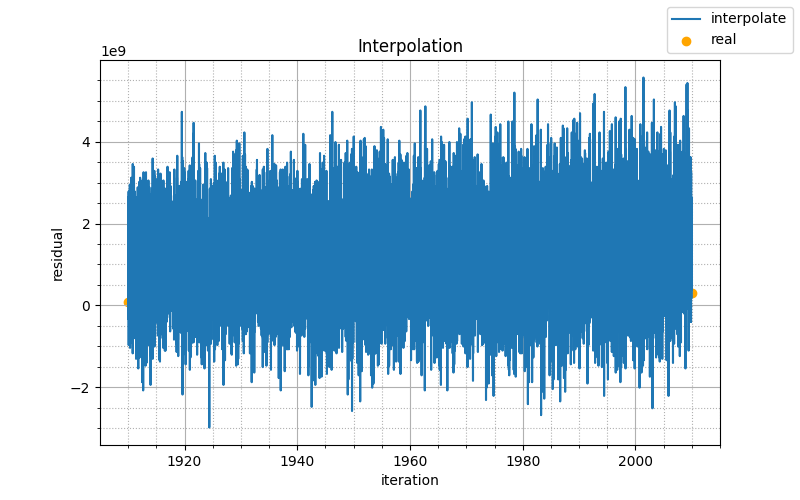

In [35]:
def gen_diff_div(x, y):
    x = np.asanyarray(x, dtype=float)
    y = np.asanyarray(y, dtype=float)
    if not isinstance(x, np.ndarray) or not isinstance(y, np.ndarray):
        raise TypeError("x or y can't be converted to np array")
    n = len(x)
    assert n == len(y)
    diffs = np.zeros((n, n))
    diffs[0, :] = y
    for col in range(1, n):
        up_b = n-col
        diffs[col, :up_b] = (diffs[col-1, 1:up_b+1] - diffs[col-1, :up_b]) / (x[col:] - x[:up_b])
    return diffs

def interpolate_newthon(x, y):
    """ 
        fits points with polynomial using Newthon's interpolation 
        returns numpy.polynomial.Polynomial 
    """
    x = np.asanyarray(x, dtype=float)
    y = np.asanyarray(y, dtype=float)
    if not isinstance(x, np.ndarray) or not isinstance(y, np.ndarray):
        raise TypeError("x or y can't be converted to np array")
    n = len(x)
    assert n == len(y)
    diffs = gen_diff_div(x, y)
    ans = Polynomial([y[0]])
    xs = Polynomial([1])
    for diff, xk in zip(diffs[1:, 0], x[:-1]):
        xs *= Polynomial([-xk, 1]) # multiply by (x-xk)
        ans += xs * diff
    return ans

ans = interpolate_newthon(x, y)
display(ans)
print(f'at x={check_x}, pred_y = {ans(check_x)}, real = {check_y}, '
      f'pred_y/real = {ans(check_x)/check_y}')

xval = np.linspace(x[0], check_x, 10000)
yval = ans(xval)

fig, ax = prep_ax('Interpolation')
ax.plot(xval, yval, label='interpolate')
ax.scatter(list(x)+[check_x], list(y)+[check_y], color='orange', label='real')
fig.legend()

## Spline

at x=2010, pred_y = 314133939.0, real = 308745538, pred_y/real = 1.0174525631525078


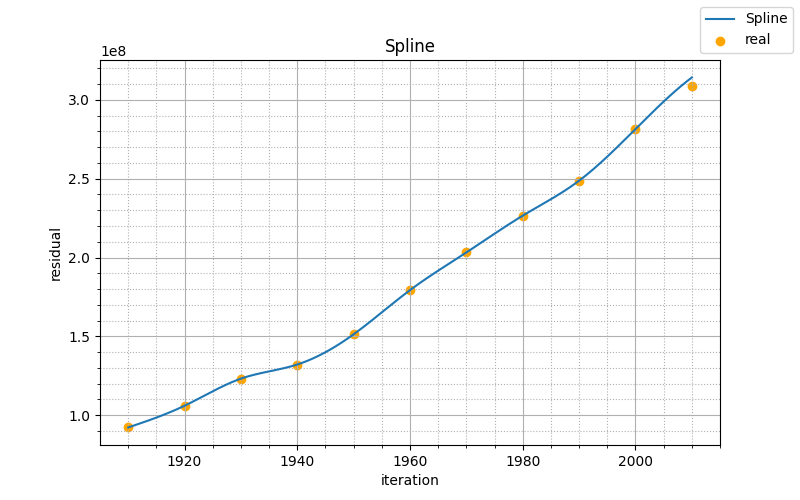

In [36]:
def spline_cubic_natural(x, y):
    """
        only for len(x)=len(y)>3
    """
    x = np.asanyarray(x, dtype=float)
    y = np.asanyarray(y, dtype=float)
    if not isinstance(x, np.ndarray) or not isinstance(y, np.ndarray):
        raise TypeError("x or y can't be converted to np array")
    n = len(x)
    assert n == len(y)
    a = y
    h = np.concatenate([[np.NaN],x[1:]-x[:-1]] )
    mat = np.zeros((n, n))
    b = np.zeros(n)
    mat[0,0]=1
    mat[-1,-1]=1
    for i in range(1, n-1):
        mat[i, i-1] = h[i]
        mat[i, i] = 2*(h[i] + h[i+1])
        mat[i, i+1] = h[i+1]
        b[i] = 3*((a[i+1]-a[i])/h[i+1] - (a[i]-a[i-1])/h[i])
    c = utils.solve_gauss(mat, b)
    d = (c[1:]-c[:-1])/3/h[1:]
    b = (a[1:]-a[:-1])/h[1:] - (c[1:]+2*c[:-1])/3*h[1:]
    return PPoly([d,c[:-1],b,a[:-1]], x)

res = spline_cubic_natural(x, y)
print(f'at x={check_x}, pred_y = {res(check_x)}, real = {check_y}, '
      f'pred_y/real = {res(check_x)/check_y}')

xval = np.linspace(x[0], check_x, 10000)
yval = res(xval)
fig, ax = prep_ax('Spline')
ax.plot(xval, yval, label='Spline')
ax.scatter(list(x)+[check_x], list(y)+[check_y], color='orange', label='real')
fig.legend()

## Least squares

$f(x) = a \cdot e^{b \cdot x} \Leftrightarrow \ln{f} = \ln{a} + b \cdot x $ 

at x=2010, pred_y = 324601931.06586426, real = 308745538, pred_y/real = 1.0513574808840291


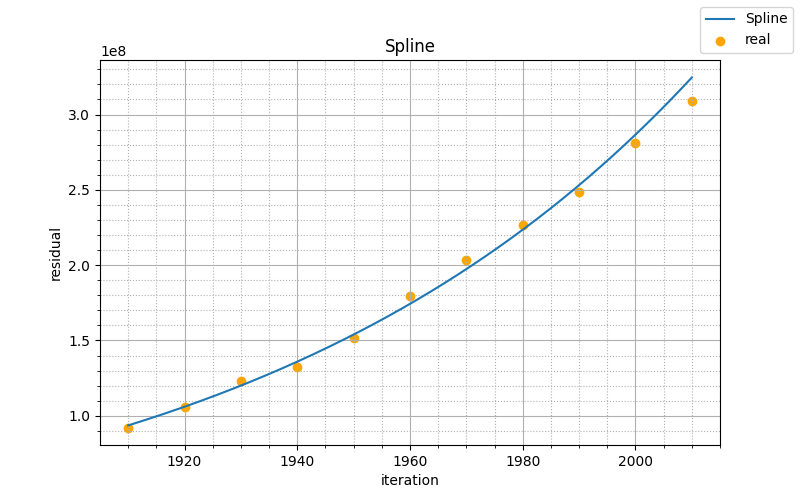

In [37]:
def approx_lin(x, y):
    mat = [[len(x), sum(x)], [sum(x), sum(x**2)]]
    b = [sum(y), sum(y*x)]
    return utils.solve_gauss(mat, b)

def approx_exp(x, y):
    a, b = approx_lin(x, np.log(y))
    a = np.exp(a)
    return lambda x: a * np.exp(b*x)

res = approx_exp(x, y)
print(f'at x={check_x}, pred_y = {res(check_x)}, real = {check_y}, '
      f'pred_y/real = {res(check_x)/check_y}')

xval = np.linspace(x[0], check_x, 10000)
yval = res(xval)
fig, ax = prep_ax('Spline')
ax.plot(xval, yval, label='Spline')
ax.scatter(list(x)+[check_x], list(y)+[check_y], color='orange', label='real')
fig.legend()